In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\user\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <Spl

In [6]:
info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [7]:
dataset['train']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [8]:
dataset['test']

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [9]:
# 이미지 정규화
# tf.cast(x, dtype, name=None)은 x를 dtype으로 변환하는 함수이다.
# tf.cast(input_image, tf.float32)는 input_image를 tf.float32로 변환해주는 것
# 그 후에 픽셀정보를 0~255사이의 값으로 가지는데, 이를 255개로 나누어 0~1.0사이의 값을 갖게 한다.
# 픽셀값이 다양할 경우, 경사하강법으로 접근함에 있어 그 폭이 굉장히 크지만, 정규화를 통해 상대적으로 경사하강법을 통해 원하는 목표에 수렴하는 것이 쉬워진다.
# 또한 기울기값이 상대적으로 변동이 크지않아 Local Minimum에 빠질 위험이 줄어들게 된다.
# input_mask의 값이 {1,2,3}이기때문에 {0,1,2}로 바꾸기 위해서 -1을 해준다
# input_mask에서 1을 빼는
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [10]:
# 이미지를 불러오기
# image와 mask를 불러와서 size를 (128,128)로 조정한다.
# tf.random.uniform(())함수는 균일분포 난수를 발생시키는 함수이다
# tf.random.uniform([x],y,z)라고 가정했을시, x는 return 받을 값의 shape, y는 최소값, z는 최대값을 의미한다
# 
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [12]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\user\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <Spl

In [13]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 500
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [14]:
# dataset.map 함수는 pandas의 map 함수와 유사하다.
# dataset 전체에 함수를 맵핑한다.
# dataset['train']에 주어진 원소를 num_parallel_cells, 즉 tf.data.experimental.AUTOTUNE 을 적용하여 새로운 데이터셋을 만든다
# tf.data.experimental.AUTOTUNE은 network가 스스로 dataset을 잘 불러올수있도록 num_parallel_calls를 적용하는 기능이다.
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [15]:
# train.cache() 함수는 해당 데이터셋이 반복되는 상황일때 캐싱해둬서 빠르게 불러오기
# shuffle(BUFFER_SIZE)는 BUFFER_SIZE 요소로 버퍼를 채운 다음 요소를 무작위로 샘플링해서 선택한 요소를 새 요소로 바꿈

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

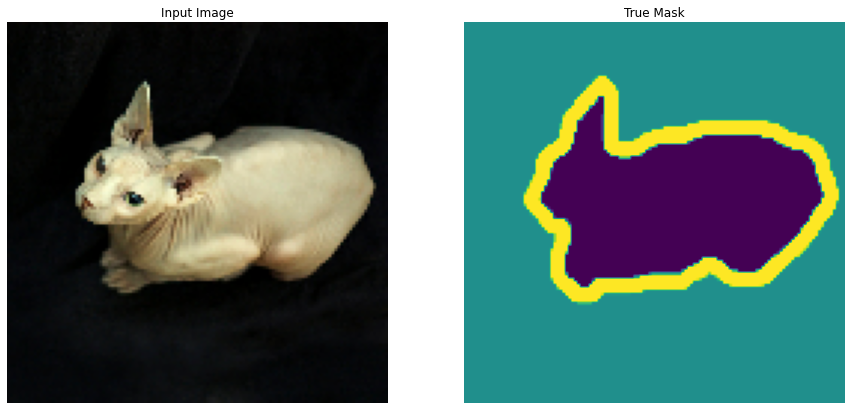

In [17]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [18]:
# 분류 가능한 라벨이 3개이기때문에 output_channel은 3으로 설정
OUTPUT_CHANNELS = 3

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭시다
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

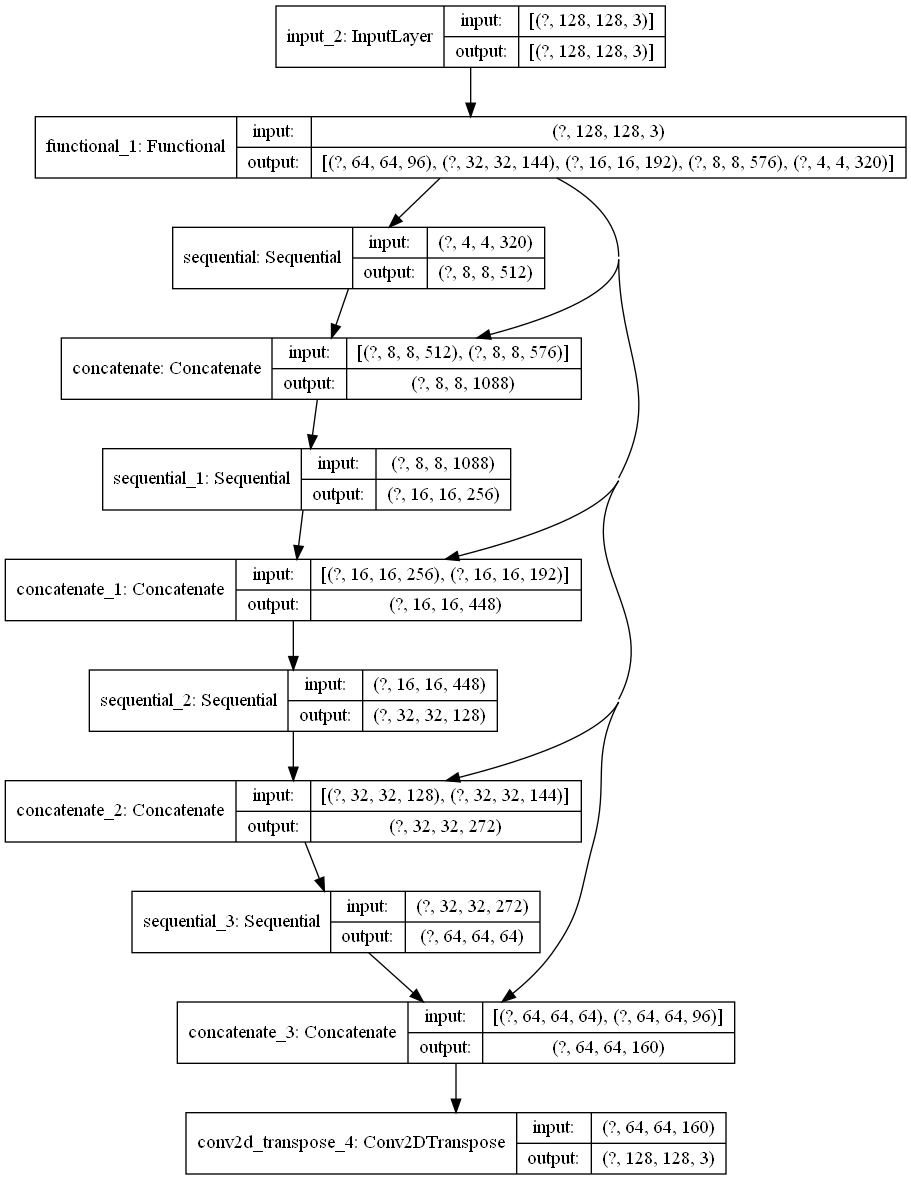

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [25]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

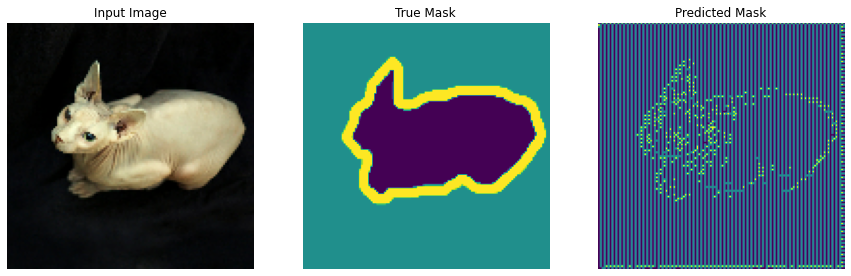

In [26]:
show_predictions()

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

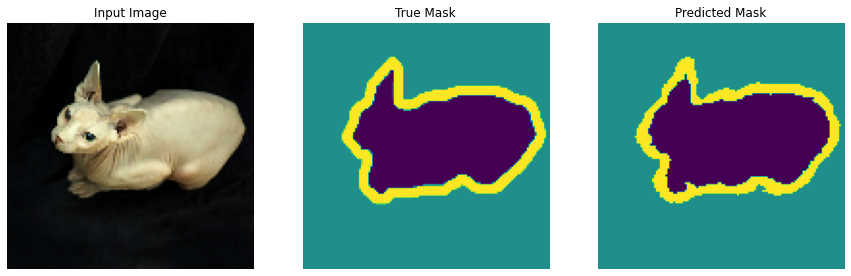


에포크 이후 예측 예시 20

57/57 [==============================] - 7s 117ms/step - loss: 0.1420 - accuracy: 0.9356 - val_loss: 0.3059 - val_accuracy: 0.8910


In [28]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

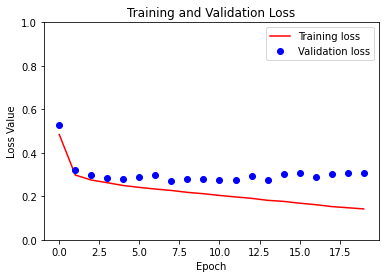

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

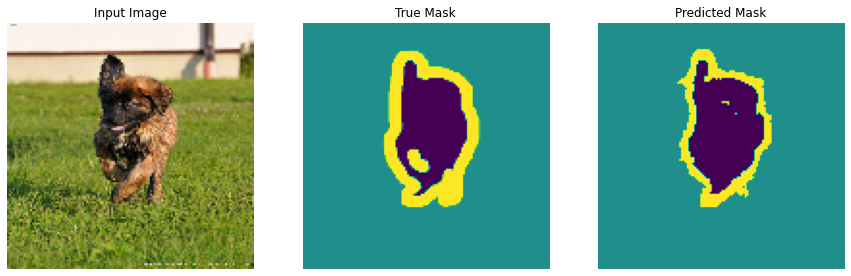

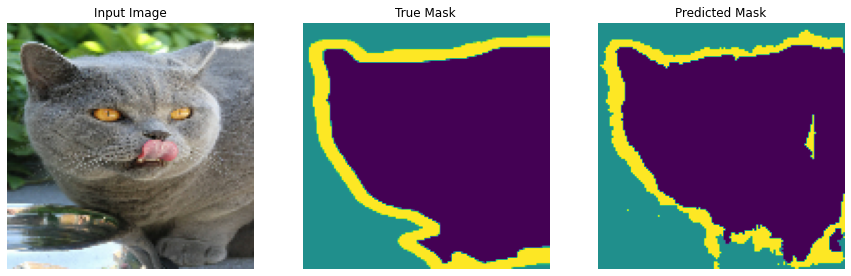

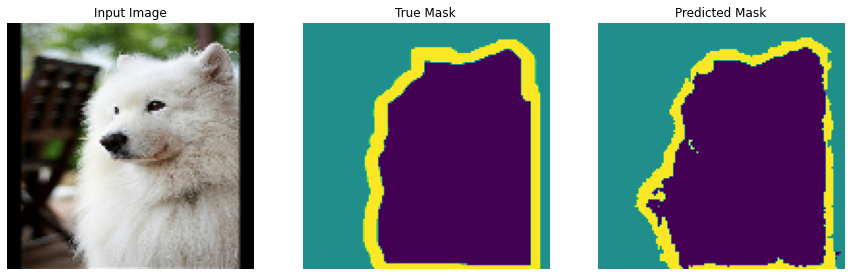

In [30]:
show_predictions(test_dataset, 3)

In [1]:
### ISBI 2012 Dataset 사용해보기 ###

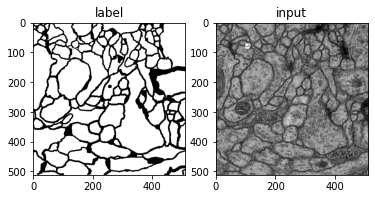

In [21]:
## 필요한 패키지 등록
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 데이터 불러오기
dir_data = 'C:/Users/user/Desktop/data/isbi-2012/data'

# label과 input 가져오기
name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))


#label의 size와 frame 개수를 얻어온다
ny, nx = img_label.size
nframe = img_label.n_frames

## 30개의 data를 train, val, test로 나누기
nframe_train = 24
nframe_val = 3
nframe_test = 3

## train, val, test 폴더 만들기
dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

## np.arange(nframe)을 통해 프레임 별 이미지를 id_frame에 저장하고, shuffle을 통해 섞는다.
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

## train, test, val 폴더에 각각 데이터 나눠담기.
offset_nframe = 0
## img_label, img_input 에서 i + offset_nframe 만큼 파일 내부에서 이동
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

##
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

In [4]:
## 부가 설명
# id_frame은 다음과 같이 담기게 된다.

print('id_frame = ',id_frame)
# 여기서 for문과 seek 함수를 통해 nframe_train 갯수만큼 id_frame[i + offset_nframe]간격으로 이동하며 label_과 input_에 배열로 저장하게된다
# 이를 폴더에 npy파일로 저장한다.
print(input_)

id_frame =  [24 25 27  8  4 13  3 29 10 18 28  9  7 21 19 17 16 14 20 15  0  5  6 26
 22 11  2 12 23  1]
[[115 131 130 ... 124 125 137]
 [115 132 131 ... 105 111 143]
 [118 127 110 ... 115 131 152]
 ...
 [125 146 144 ... 169 172 174]
 [150 169 155 ... 177 178 172]
 [139 139 128 ... 182 171 155]]


In [5]:
## 데이터셋 만들기
training_data = []
training_label = []
val_data = []
val_label = []
test_data = []
test_label = []

def create_training_data():
    
    for train_data_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/train/'+'input_%03d'%i+".npy" for i in range(24)]:
        training_data.append(np.load(train_data_temp))
    training_datas = np.dstack(training_data)
    return training_datas
        

def create_training_label():
    
    for train_label_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/train/'+'label_%03d'%i+".npy" for i in range(24)]:
        training_label.append(np.load(train_label_temp))
    training_labels = np.dstack(training_label)
    return training_labels
            
def create_val_data():
    
    for val_data_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/val/'+'input_%03d'%i+".npy" for i in range(6)]:
        val_data.append(np.load(val_data_temp))
    val_datas = np.dstack(val_data)
    return val_datas

def create_val_label():
    
    for val_label_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/val/'+'label_%03d'%i+".npy" for i in range(6)]:
        val_label.append(np.load(val_label_temp))
    val_labels = np.dstack(val_label)
    return val_labels

def create_test_data():

    for test_data_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/test/'+'input_%03d'%i+".npy" for i in range(3)]:
        test_data.append(np.load(test_data_temp))
    test_datas = np.dstack(test_data)
    return test_datas

def create_test_label():
    
    for test_label_temp in ['C:/Users/user/Desktop/data/isbi-2012/data/test/'+'label_%03d'%i+".npy" for i in range(3)]:
        test_label.append(np.load(test_label_temp))
    test_labels = np.dstack(test_label)
    return test_labels

In [79]:
history = model.fit(resizing_training_data, [resizing_training_label], validation_data=(resizing_val_data, [resizing_val_label]),epochs = 5, batch_size = 16, verbose = 1)

Epoch 1/5


ValueError: in user code:

    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\pooling.py:296 call
        data_format=conv_utils.convert_data_format(self.data_format, 4))
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_ops.py:4521 max_pool
        name=name)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:5269 max_pool
        data_format=data_format, name=name)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    c:\users\user\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node functional_9/max_pooling2d_24/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_9/conv2d_146/Relu)' with input shapes: [16,128,1,64].


In [72]:
training_data.shape

(512, 512, 24)